In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import torch
import timm
import torchvision.transforms as transforms
from collections import OrderedDict
from epillid_src.models.embedding_model import EmbeddingModel
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import pymysql
import pandas as pd

In [2]:
model = EmbeddingModel(network='resnet101')
pt = torch.load('ePillID_data/classification_results/lr0.0001_dr0.0_lrpatience2_lrfactor0.5_resnet101_202206090720/pilltypeid_nih_sidelbls0.01_metric_5folds_0.csv.pth')
#model.load_state_dict(pt)

In [3]:
temp = OrderedDict()
for i, j in pt.items():   # search all key from model
    if i.startswith("embedding_model."):
        name = i.replace("embedding_model.","")  # change key that doesn't match
        temp[name] = j

In [4]:
model.load_state_dict(temp)

<All keys matched successfully>

In [5]:
torch.save(model.state_dict(),'../pill_encoder.pt')

In [6]:
model = model.cuda().eval()

In [7]:
def subimage(image, rect):
    theta = rect[2]-90
    center = (int(rect[0][0]),int(rect[0][1]))
    height = int(rect[1][0])
    width = int(rect[1][1])
    theta *= 3.14159 / 180 # convert to rad
    v_x = (np.cos(theta), np.sin(theta))
    v_y = (-np.sin(theta), np.cos(theta))
    s_x = center[0] - v_x[0] * ((width-1) / 2) - v_y[0] * ((height-1) / 2)
    s_y = center[1] - v_x[1] * ((width-1) / 2) - v_y[1] * ((height-1) / 2)

    mapping = np.array([[v_x[0],v_y[0], s_x],
                        [v_x[1],v_y[1], s_y]])

    cropped = cv2.warpAffine(image,mapping,(width, height),flags=cv2.WARP_INVERSE_MAP,borderMode=cv2.BORDER_REPLICATE)
    if cropped.shape[0] > cropped.shape[1]:
        cropped = cv2.rotate(cropped,cv2.ROTATE_90_COUNTERCLOCKWISE)
    cropped = cv2.resize(cropped,(224,int(224*cropped.shape[0]/cropped.shape[1])))
    zero_image = np.zeros((224,224,3),dtype=np.uint8)
    zero_image[112-cropped.shape[0]//2 : 112 +(cropped.shape[0]-cropped.shape[0]//2),:] = cropped
    return zero_image

In [8]:
def cosine_distance(a,b):
    dis = np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return dis

In [9]:
res_mean = [0.485, 0.456, 0.406]
res_std = [0.229, 0.224, 0.225]

torch_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(res_mean, res_std)
])

In [10]:
image = np.array(Image.open('nox_front.png'))
if image.shape[-1] == 4:
    image = cv2.cvtColor(image,cv2.COLOR_RGBA2RGB)
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, th = cv2.threshold(imgray, 10,255,cv2.THRESH_BINARY)

# 컨튜어 찾기
contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contr = contours[0]
rect = cv2.minAreaRect(contr)

In [11]:
crop_f = subimage(image,rect)

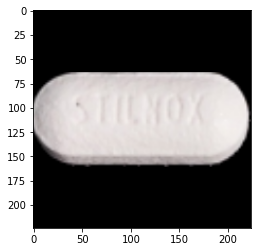

In [12]:
plt.imshow(crop_f)

In [13]:
image = np.array(Image.open('nox_back.png'))
if image.shape[-1] == 4:
    image = cv2.cvtColor(image,cv2.COLOR_RGBA2RGB)
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, th = cv2.threshold(imgray, 10,255,cv2.THRESH_BINARY)

# 컨튜어 찾기
contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contr = contours[0]
rect = cv2.minAreaRect(contr)

In [14]:
crop_b = subimage(image,rect)

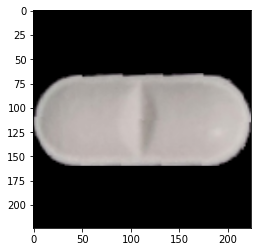

In [15]:
plt.imshow(crop_b)

In [16]:
with torch.no_grad():
    crop_ft = torch_transform(crop_f).cuda()
    crop_bt = torch_transform(crop_b).cuda()
    feat_g_ft = model(crop_ft.unsqueeze(0)).squeeze().detach().cpu().numpy()
    feat_g_ft /=np.linalg.norm(feat_g_ft)
    feat_g_bt = model(crop_bt.unsqueeze(0)).squeeze().detach().cpu().numpy()
    feat_g_bt /=np.linalg.norm(feat_g_bt)

/opt/ml/final-project-level3-cv-16/ePillID_benchmark/epillid_src/models/fast-MPN-COV/src/representation/CBP.py:78: UserWarning: The function torch.fft is deprecated and will be removed in PyTorch 1.8. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.fftn. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/aten/src/ATen/native/SpectralOps.cpp:567.)
  sketch1 = torch.fft(torch.cat((sketch1, torch.zeros(sketch1.size(), device=x.device)), dim=2), 1)
/opt/ml/final-project-level3-cv-16/ePillID_benchmark/epillid_src/models/fast-MPN-COV/src/representation/CBP.py:86: UserWarning: The function torch.ifft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.ifftn. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/aten/src/ATen/native/SpectralOps.cpp:578.)
  tmp_y = torc

In [17]:
image = np.array(Image.open('image_normalized/200700634.png'))
if image.shape[-1] == 4:
    image = cv2.cvtColor(image,cv2.COLOR_RGBA2RGB)
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, th = cv2.threshold(imgray, 10,255,cv2.THRESH_BINARY)

# 컨튜어 찾기
contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contr = contours[0]
rect = cv2.minAreaRect(contr)

In [18]:
crop_ref_f = cv2.resize(image[:256,:256],dsize=(224,224))

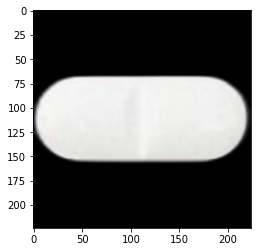

In [19]:
plt.imshow(crop_ref_f)

In [20]:
crop_ref_b = cv2.resize(image[256:,256:],dsize=(224,224))

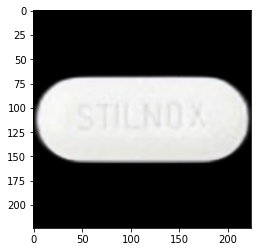

In [21]:
plt.imshow(crop_ref_b)

In [22]:
with torch.no_grad():
    crop_ft = torch_transform(crop_ref_f).cuda()
    crop_bt = torch_transform(crop_ref_b).cuda()
    feat_ft = model(crop_ft.unsqueeze(0)).squeeze().detach().cpu().numpy()
    feat_bt = model(crop_bt.unsqueeze(0)).squeeze().detach().cpu().numpy()

In [26]:
np.linalg.norm(feat_g_ft)

1.0

In [28]:
dis = cosine_distance(feat_g_ft,feat_bt)
dis = (dis +cosine_distance(feat_g_bt, feat_ft))/2

In [29]:
dis

0.7424263954162598

In [33]:
ref_imgs = 'image_normalized'
np_dir = '../features'

In [35]:
dis = 0
for f in tqdm(os.listdir(ref_imgs)):
    image = np.array(Image.open(os.path.join(ref_imgs,f)))
    if image.shape[-1] == 4:
        image = cv2.cvtColor(image,cv2.COLOR_RGBA2RGB)
    img_f = cv2.resize(image[:256,:256],(224,224))
    img_b = cv2.resize(image[256:,256:],(224,224))
    img_ft = torch_transform(img_f).cuda()
    img_bt = torch_transform(img_b).cuda()
    with torch.no_grad():
        img_f_feat = model(img_ft.unsqueeze(0)).detach().cpu().numpy()
        img_b_feat = model(img_bt.unsqueeze(0)).detach().cpu().numpy()
        img_feat = np.concatenate((img_f_feat/np.linalg.norm(img_f_feat),img_b_feat/np.linalg.norm(img_b_feat)),axis=0)
        t = max(np.dot(feat_g_bt,img_feat[0])+np.dot(feat_g_ft,img_feat[1]),np.dot(feat_g_bt,img_feat[1])+np.dot(feat_g_ft,img_feat[0]))/2
        if t > dis:
            dis = t
            print(t,f)
        np.save(os.path.join(np_dir,f.split('.')[0]+'.npy'),img_feat)

  0%|          | 2/24358 [00:00<55:03,  7.37it/s]

0.14121198654174805 201905353.png


  0%|          | 4/24358 [00:00<54:47,  7.41it/s]

0.3428287208080292 202009212.png


  0%|          | 8/24358 [00:01<59:37,  6.81it/s]  

0.5398749113082886 200501120.png


  0%|          | 13/24358 [00:01<57:02,  7.11it/s]

0.6145839095115662 201404863.png


  0%|          | 16/24358 [00:02<54:23,  7.46it/s]

0.6320146322250366 200503642.png


  0%|          | 112/24358 [00:15<49:59,  8.08it/s] 

0.6407313346862793 202004700.png


  1%|          | 286/24358 [00:37<46:14,  8.68it/s]  

0.6444828510284424 200401327.png


  2%|▏         | 418/24358 [00:54<51:28,  7.75it/s]  

0.6916301250457764 200001713.png


  4%|▎         | 878/24358 [01:54<43:08,  9.07it/s]  

0.6964889764785767 201600217.png


 17%|█▋        | 4200/24358 [08:58<49:11,  6.83it/s]  

0.7424263954162598 200700634.png


 24%|██▍       | 5796/24358 [12:20<32:34,  9.50it/s]  

0.755526065826416 200711589.png


 84%|████████▍ | 20530/24358 [44:00<08:07,  7.85it/s] 

0.7694981098175049 200201314.png


100%|██████████| 24358/24358 [51:06<00:00,  7.94it/s]


In [36]:
l = []
for f in tqdm(os.listdir(np_dir)):
    #try:
    q_feat = np.load(os.path.join(np_dir,f))
    dis =max(np.dot(feat_g_bt,q_feat[0]) + np.dot(feat_g_ft,q_feat[1]),np.dot(feat_g_bt,q_feat[1])+np.dot(feat_g_ft,q_feat[0]))/2
    l.append((dis,f.split('.')[0]))

100%|██████████| 24358/24358 [00:08<00:00, 2908.56it/s]


In [37]:
l.sort(reverse=True)
l[:40]

[(0.7694981098175049, '200201314'),
 (0.7669973373413086, '201507615'),
 (0.755526065826416, '200711589'),
 (0.7536742687225342, '200701891'),
 (0.7454590797424316, '199800711'),
 (0.7424263954162598, '200700634'),
 (0.7310341596603394, '200711762'),
 (0.7269319891929626, '200402698'),
 (0.7210027575492859, '200301752'),
 (0.7207303643226624, '200512162'),
 (0.7192889451980591, '199401316'),
 (0.7189803123474121, '201701413'),
 (0.7134549617767334, '200402672'),
 (0.7077062129974365, '201006109'),
 (0.7037867307662964, '200201695'),
 (0.7003733515739441, '200410504'),
 (0.6975904703140259, '200701245'),
 (0.6964889764785767, '201600217'),
 (0.6916301250457764, '200001713'),
 (0.6906792521476746, '199801849'),
 (0.6879706382751465, '201107004'),
 (0.6875193119049072, '200604164'),
 (0.6844684481620789, '200003096'),
 (0.6834677457809448, '200608232'),
 (0.683040201663971, '199001164'),
 (0.6815516352653503, '199802795'),
 (0.681193470954895, '200308497'),
 (0.6803255081176758, '20070990

In [3]:
model = timm.create_model('resnet50',checkpoint_path ='../best_type_and_shape.ckpt',num_classes = 11)

In [3]:
df = pd.read_csv('dropped.csv')

In [10]:
import base64

In [22]:
b_feats = []